# Problem Description: acosx -> asinx

Governing PDE: $$ G:u(x)=acos(x)↦v(x)=asin(x), \in [-1,1],\quad a\in [1,10]$$

Initial Condition: $$u(0) = a$$
Boundary Condition: $$v(0) = 0$$


In [93]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda:0


In [ ]:
torch.manual_seed(42)
np.random.seed(42)

N_samples = 500 
Batch_size = 50 
N_sensors = 30
N_trunk = 30  

a_values = torch.rand(N_samples, 1).to(device) * 10.0  
x_coords = torch.linspace(0.0, 3.0, N_sensors).to(device) 
f_sensors = a_values * torch.cos(x_coords) 

x_trunk = torch.linspace(0.0, 3.0, N_trunk).unsqueeze(1).to(device)
u_true = a_values * torch.sin(x_trunk.T)

print(f"Branch Input shape: {f_sensors.shape}")
print(f"Trunk Input shape: {x_trunk.shape}")
print(f"Ground Truth shape: {u_true.shape}")

Branch Input shape: torch.Size([500, 30])
Trunk Input shape: torch.Size([30, 1])
Ground Truth shape: torch.Size([500, 30])


In [95]:
full_dataset = TensorDataset(f_sensors, u_true, a_values)

train_size = int(0.7 * N_samples)
test_size = N_samples - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size], generator=torch.Generator())

train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=Batch_size, shuffle=False)

print(f"Total samples: {N_samples}")
print(f"Train samples: {len(train_dataset)} | Test samples: {len(test_dataset)}")
print(f"Number of batches per epoch (Train): {len(train_loader)}")

Total samples: 500
Train samples: 350 | Test samples: 150
Number of batches per epoch (Train): 7


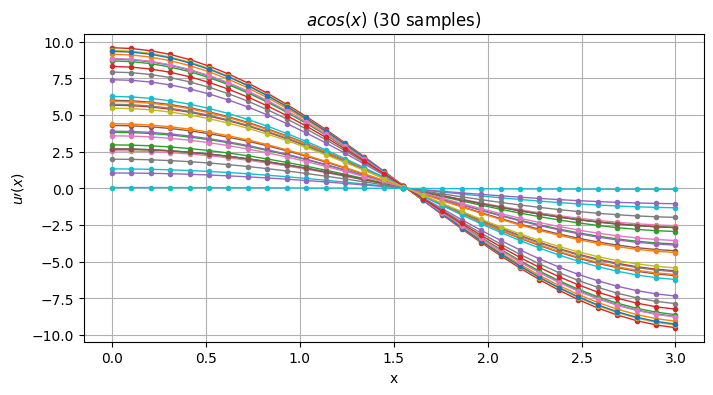

In [112]:
plt.figure(figsize=(8, 4))
for i in range(30):
    plt.plot(x_coords.cpu(), f_sensors[i].cpu(), 'o-', ms=3, alpha=1, linewidth=1)
plt.xlabel("x")
plt.ylabel('$u\prime(x)$')
plt.title("$acos(x)$ (30 samples)")
plt.grid(True)
plt.savefig(f"C:/Users/admin/Desktop/김도형/코드/figure_20260220_labmeeting/PI-DoN_simpleODE_branch_input.png", dpi=300, bbox_inches="tight")
plt.show()

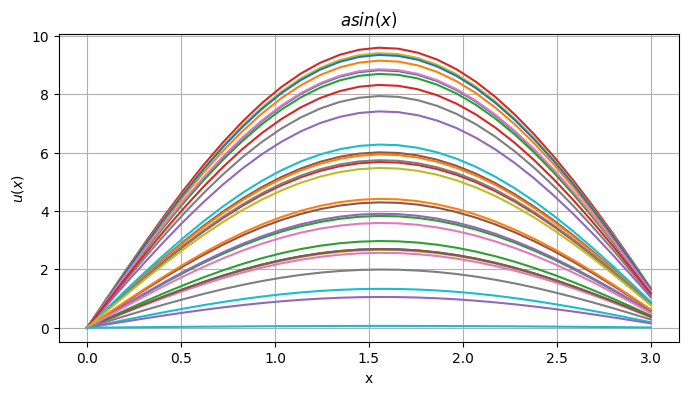

In [114]:
plt.figure(figsize=(8, 4))
for i in range(30):
    plt.plot(x_coords.cpu(), u_true[i].cpu())
plt.xlabel("x")
plt.ylabel('$u(x)$')
plt.title("$asin(x)$")
plt.grid(True)
plt.savefig(f"C:/Users/admin/Desktop/김도형/코드/figure_20260220_labmeeting/PI-DoN_simpleODE_branch_input.png", dpi=300, bbox_inches="tight")
plt.show()

In [98]:
class PIDeepONet(nn.Module):
    def __init__(self, sensors=30, trunk_dim=1, width=64, p=64):
        super().__init__()
        act = nn.Tanh()
        
        self.branch = nn.Sequential(
            nn.Linear(sensors, width), act,
            nn.Linear(width, width), act,
            nn.Linear(width, p)
        )
        
        self.trunk = nn.Sequential(
            nn.Linear(trunk_dim, width), act,
            nn.Linear(width, width), act,
            nn.Linear(width, p)
        )
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, branch_in, trunk_in):
        b = self.branch(branch_in)  # (B, p)
        
        if trunk_in.dim() == 2:
            t = self.trunk(trunk_in)
            u = torch.matmul(b, t.T) + self.bias  # (B, N)
        elif trunk_in.dim() == 3:
            t = self.trunk(trunk_in)
            u = torch.bmm(b.unsqueeze(1), t.transpose(1, 2)).squeeze(1) + self.bias # (B, N)
        return u

model = PIDeepONet(sensors=30, trunk_dim=1, width=64, p=64).to(device)

In [99]:
def train_step(model, optimizer, f_in, u_tr, a_val, x_tr, w_data=1.0, w_pde=1.0, w_ic=1.0):
    model.train()
    optimizer.zero_grad()
    B_size = f_in.shape[0]

    # 1) Data Loss
    u_pred = model(f_in, x_tr) # (B, 20)
    loss_data = torch.mean((u_pred - u_tr)**2)

    # 2) PDE Loss
    x_pde = x_tr.unsqueeze(0).expand(B_size, -1, -1).clone().requires_grad_(True) 
    u_pde = model(f_in, x_pde) # (B, 20)
    
    du_dx = torch.autograd.grad(
        outputs=u_pde,
        inputs=x_pde,
        grad_outputs=torch.ones_like(u_pde),
        create_graph=True
    )[0].squeeze(-1) # (B, 20)
    
    f_true = a_val * torch.cos(x_pde.squeeze(-1)) # (B, 20)
    loss_pde = torch.mean((du_dx - f_true)**2)

    # 3) IC Loss: u(0) = 0
    x_ic = torch.zeros(B_size, 1, 1, device=device)
    u_ic = model(f_in, x_ic).squeeze(-1) # (B, 1)
    loss_ic = torch.mean(u_ic**2)

    # Total Loss
    loss = w_data * loss_data + w_pde * loss_pde + w_ic * loss_ic
    loss.backward()
    optimizer.step()

    return loss.item(), loss_data.item(), loss_pde.item(), loss_ic.item()

In [100]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)

n_epochs = 3000
print("\nStarting Training...")
for epoch in range(1, n_epochs + 1):
    w_pde = 0.1 if epoch < 300 else 1.0 # 초반 Data 위주, 후반 PDE 위주 학습
    
    epoch_loss = epoch_data = epoch_pde = epoch_ic = 0.0
    
    # train_loader를 사용하여 학습 진행
    for batch_f, batch_u, batch_a in train_loader:
        l_tot, l_d, l_p, l_i = train_step(
            model, optimizer, batch_f, batch_u, batch_a, x_trunk, w_pde=w_pde
        )
        epoch_loss += l_tot
        epoch_data += l_d
        epoch_pde += l_p
        epoch_ic += l_i
        
    scheduler.step()

    n_batches = len(train_loader)
    if epoch % 100 == 0:
        lr = optimizer.param_groups[0]['lr']
        print(f"[Epoch {epoch:4d}] LR={lr:.4f} | Total: {epoch_loss/n_batches:.4e} | Data: {epoch_data/n_batches:.4e} | PDE: {epoch_pde/n_batches:.4e}")


Starting Training...
[Epoch  100] LR=0.0010 | Total: 7.8591e-03 | Data: 5.8941e-03 | PDE: 1.5163e-02
[Epoch  200] LR=0.0010 | Total: 3.8347e-03 | Data: 2.9507e-03 | PDE: 7.7334e-03
[Epoch  300] LR=0.0005 | Total: 2.2917e+00 | Data: 1.5073e+00 | PDE: 7.0139e-01
[Epoch  400] LR=0.0005 | Total: 3.6573e-03 | Data: 1.0213e-03 | PDE: 2.5938e-03
[Epoch  500] LR=0.0005 | Total: 9.2377e-04 | Data: 2.3170e-04 | PDE: 6.8540e-04
[Epoch  600] LR=0.0003 | Total: 1.7970e-03 | Data: 9.4831e-04 | PDE: 8.0484e-04
[Epoch  700] LR=0.0003 | Total: 4.0701e-04 | Data: 1.6777e-04 | PDE: 2.3356e-04
[Epoch  800] LR=0.0003 | Total: 5.9621e-04 | Data: 3.0300e-04 | PDE: 2.8152e-04
[Epoch  900] LR=0.0001 | Total: 5.3406e-04 | Data: 2.7615e-04 | PDE: 2.4594e-04
[Epoch 1000] LR=0.0001 | Total: 3.8743e-04 | Data: 1.9746e-04 | PDE: 1.7809e-04
[Epoch 1100] LR=0.0001 | Total: 2.0018e-04 | Data: 8.9285e-05 | PDE: 1.0843e-04
[Epoch 1200] LR=0.0001 | Total: 2.5878e-04 | Data: 1.2815e-04 | PDE: 1.2561e-04
[Epoch 1300] LR=0.

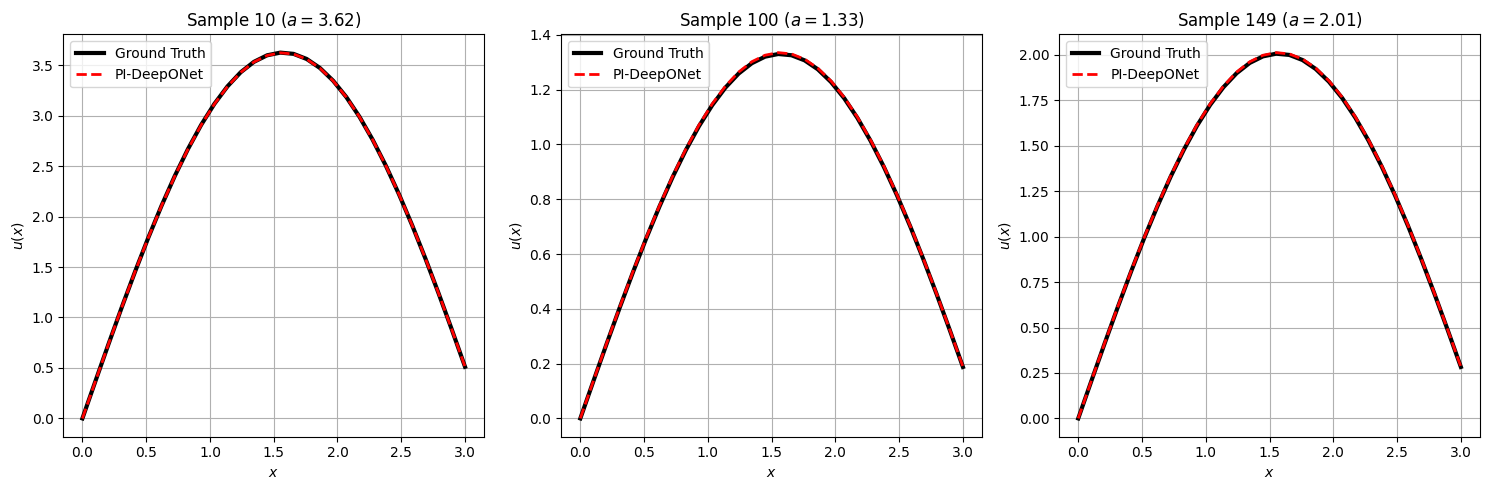

In [ ]:
model.eval()

# 테스트 데이터셋에서 모든 데이터를 추출하여 평가
test_f_sensors = test_dataset[:][0]
test_u_true = test_dataset[:][1]
test_a_values = test_dataset[:][2] 

with torch.no_grad():
    # 학습에 사용되지 않은 테스트 데이터(test_f_sensors)를 입력으로 예측
    u_pred_test = model(test_f_sensors, x_trunk).cpu().numpy()

# 테스트 데이터 200개 중 랜덤하게 3개 추출하여 시각화
sample_indices = [10, 100, 149] 
x_np = x_trunk.cpu().numpy().flatten()
u_true_test_np = test_u_true.cpu().numpy()

plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_indices):
    a_val = test_a_values[idx].item()
    
    plt.subplot(1, 3, i+1)
    plt.plot(x_np, u_true_test_np[idx], 'k-', linewidth=3, label="Ground Truth")
    plt.plot(x_np, u_pred_test[idx], 'r--', linewidth=2, label="PI-DeepONet")
    plt.title(f"Sample {idx} ($a = {a_val:.2f}$)")
    plt.xlabel("$x$")
    plt.ylabel("$u(x)$")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"C:/Users/admin/Desktop/김도형/코드/figure_20260220_labmeeting/PI-DoN_simpleODE_result.png", dpi=300, bbox_inches="tight")
plt.show()


 [Test Dataset Evaluation] 
Average MSE : 1.7583e-05
Maximum MSE : 9.3263e-05
Minimum MSE : 3.0456e-07
Std Dev     : 1.9536e-05


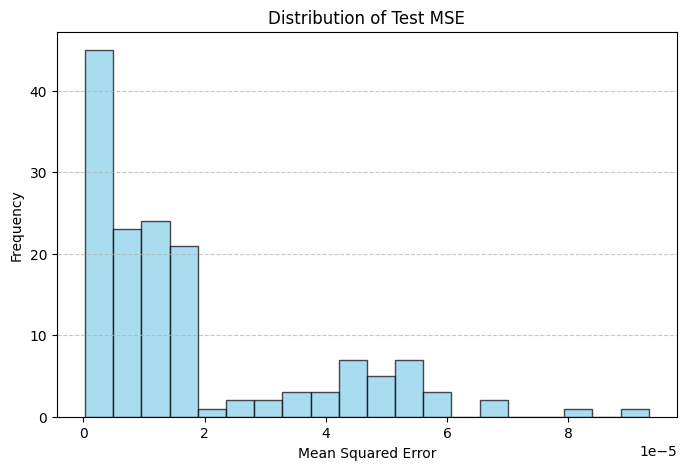

In [102]:
# -------------------------
# 7. 테스트 데이터 성능 평가 (평균, 최대, 최소 Loss)
# -------------------------
model.eval()
all_test_mse = []

with torch.no_grad():
    for batch_f, batch_u, _ in test_loader:
        # 1) 모델 예측: (Batch_size, N_trunk)
        u_pred = model(batch_f, x_trunk)
        
        # 2) 샘플별 MSE 계산
        # u_pred와 batch_u의 차이의 제곱을 공간(dim=1)에 대해 평균내어 
        # 각 샘플당 하나의 오차값을 얻습니다.
        mse_per_sample = torch.mean((u_pred - batch_u)**2, dim=1)
        
        # 3) 계산된 오차들을 리스트에 저장
        all_test_mse.extend(mse_per_sample.cpu().numpy())

# 결과를 넘파이 배열로 변환
all_test_mse = np.array(all_test_mse)

# 4) 통계치 계산
avg_loss = np.mean(all_test_mse)
max_loss = np.max(all_test_mse)
min_loss = np.min(all_test_mse)
std_loss = np.std(all_test_mse) # 표준편차도 추가하면 분석에 도움이 됩니다.

print(f"\n" + "="*30)
print(f" [Test Dataset Evaluation] ")
print(f"="*30)
print(f"Average MSE : {avg_loss:.4e}")
print(f"Maximum MSE : {max_loss:.4e}")
print(f"Minimum MSE : {min_loss:.4e}")
print(f"Std Dev     : {std_loss:.4e}")
print(f"="*30)

# (선택 사항) 오차 분포 히스토그램 시각화
plt.figure(figsize=(8, 5))
plt.hist(all_test_mse, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Test MSE")
plt.xlabel("Mean Squared Error")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()